In [2]:
import pandas as pd
import json
import math as m
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import collections
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
data_json = []
with open('data/dblp-ref-0.json') as f:
    for line in f:
        data_json.append(json.loads(line))

In [4]:
df = pd.DataFrame(data_json)

In [5]:
df = df[df['abstract'].notnull()]

In [6]:
research_words = set(line.strip() for line in open('data/research_words.txt'))

In [7]:
parentdomain = {
    "coding theory" : "mathematical foundations",
    "game theory" : "mathematical foundations",
    "graph theory" : "mathematical foundations",
    "mathematical logic" : "mathematical foundations",
    "boolean logic" : "mathematical foundations",
    "number theory" : "mathematical foundations",
    "mathematical foundations" : "mathematical foundations",
    "algorithms" : "algorithms and data structures",
    "data structures" : "algorithms and data structures",
    "algorithms and data structures" : "algorithms and data structures",
    "automated reasoning" : "artificial intelligence",
    "computer vision" : "artificial intelligence",
    "machine learning" : "artificial intelligence",
    "robotics" : "artificial intelligence",
    "speech processing" : "artificial intelligence",
    "data mining" : "artificial intelligence",
    "evolutionary computing" : "artificial intelligence",
    "natural language processing" : "artificial intelligence",    
    "artificial intelligence" : "artificial intelligence",
    "neural network" : "artificial intelligence",
    "information retrieval" : "artificial intelligence",
    "networking" : "communication and security",
    "computer networks" : "communication and security",
    "communication networks" : "communication and security",
    "network attacks" : "communication and security",
    "cryptography" : "communication and security",
    "communication and security" : "communication and security",
    "network protocols" : "communication and security",
    "operating systems" : "computer architecture",
    "computer architecture" : "computer architecture",
    "image processing" : "computer graphics",
    "information visualization" : "computer graphics",
    "information visualisation" : "computer graphics",
    "visualization" : "computer graphics",
    "visualisation" : "computer graphics",
    "computer graphics" : "computer graphics",
    "graphics" : "computer graphics",
    "parallel computing" : "concurrent, parallel, and distributed systems",
    "concurrency" : "concurrent, parallel, and distributed systems",
    "distributed computing" : "concurrent, parallel, and distributed systems",
    "distributed systems" : "concurrent, parallel, and distributed systems",
    "concurrent, parallel, and distributed systems" : "concurrent, parallel, and distributed systems",
    "relational databases" : "databases",
    "structured storage" : "databases",
    "databases" : "databases",
    "compiler theory" : "programming languages and compilers",
    "programming language" : "programming languages and compilers",
    "programming language pragmatics" : "programming languages and compilers",
    "programming language theory" : "programming languages and compilers",
    "formal semantics" : "programming languages and compilers",
    "type theory" : "programming languages and compilers",
    "programming languages and compilers" : "programming languages and compilers",
    "computational science" : "scientific computing",
    "numerical analysis" : "scientific computing",
    "symbolic computation " : "scientific computing",
    "computational physics" : "scientific computing",
    "computational chemistry" : "scientific computing",
    "bioinformatics" : "scientific computing",
    "computational biology" : "scientific computing",
    "computational neuroscience" : "scientific computing",
    "scientific computing" : "scientific computing",
    "formal methods" : "software engineering",
    "algorithm design" : "software engineering",
    "computer programming" : "software engineering",
    "human–computer interaction" : "software engineering",
    "reverse engineering" : "software engineering",
    "software engineering" : "software engineering",
    "automata theory " : "theory of computation",
    "computability theory" : "theory of computation",
    "computational complexity theory" : "theory of computation",
    "quantum computing" : "theory of computation",
    "theory of computation" : "theory of computation",   
}

In [8]:
df_copy = df.copy()
def getdomainlist(row):
    abst = row['abstract'] if type(row['abstract']) != float else ""
    venue = row['venue'] if type(row['venue']) != float else ""
    
    text = abst + " " + row['title'] + " " + venue
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    output1 = list(ngrams(tokens, 1))
    output2 = list(ngrams(tokens, 2))
    output3 = list(ngrams(tokens, 3))
    output = []
    for words in output1:
        output.append(' '.join(words))
    for words in output2:
        output.append(' '.join(words))
    for words in output3:
        output.append(' '.join(words))
    domainlist = set()
    for word in output:
        if word in parentdomain:
            domainlist.add(parentdomain[word])
    if len(domainlist) > 0 :
        return list(domainlist)[0]
    else:
        return ""

df_copy['domain'] = df_copy.apply(getdomainlist, axis = 1)

In [9]:
dffinal = df_copy[df_copy['domain'].map(lambda x: len(x) >0)]

In [10]:
dffinal['text'] = dffinal[['abstract', 'title', 'venue']].apply(lambda x: ' '.join(x), axis=1)

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(dffinal['text'].head(30000), dffinal['domain'].head(30000), random_state = 0)

pipeline = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge'))
                     ])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=10,
                               verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:  4.6min finished
/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [12]:
df['text'] = df[['abstract', 'title']].apply(lambda x: ' '.join(x), axis=1)

In [13]:
len(df)

753646

In [14]:
answer = grid_search.predict(df['text'].values.tolist())

In [15]:
df['domain'] = answer.tolist()

In [16]:
dfplot = df.groupby('domain').count().reset_index()

In [17]:
dfplot1 = dfplot[['domain','text']]

In [111]:
tempdfplot1 = dfplot1.drop([7,11,3])

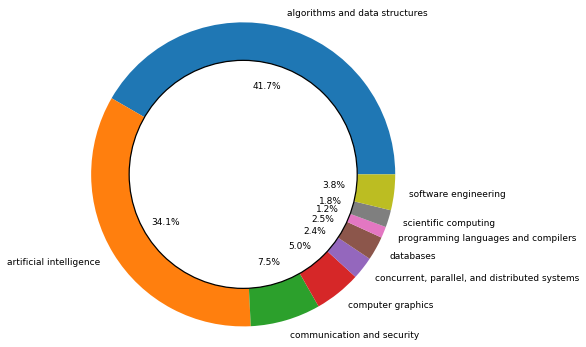

In [115]:
from matplotlib import colors as mcolors

plt.figure(figsize=(6,6))
colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)
labels = tempdfplot1['domain'].head(10)
sizes = tempdfplot1['text'].head(10)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
# colors = blend_soft_light(rgb, intensity)
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

              Fig: Popularity of domains in research work

In [18]:
startups = pd.read_csv("data/startups.csv")

In [30]:
startups = startups.dropna()

In [31]:
t = grid_search.predict(startups['description'].values.tolist())

In [32]:
startups['domain'] = pd.Series(t).values

In [33]:
startupplot = startups.groupby('domain').count().reset_index()

In [34]:
startupplot1 = startupplot[['domain','description']]

In [35]:
startupplot1

,domain,description
0,algorithms and data structures,17890
1,artificial intelligence,11166
2,communication and security,3737
3,computer architecture,143
4,computer graphics,1347
5,"concurrent, parallel, and distributed systems",216
6,databases,403
7,mathematical foundations,233
8,programming languages and compilers,47
9,scientific computing,217


In [36]:
tempstartup = startupplot1.drop([3,11,8,9])

In [37]:
tempstartup = tempstartup.drop([0])

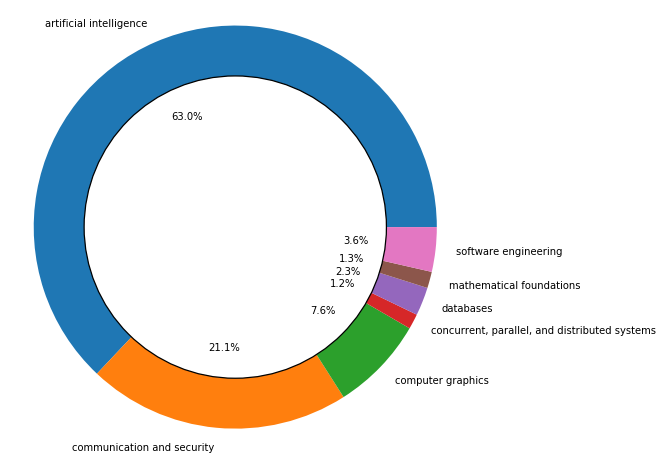

In [38]:
from matplotlib import colors as mcolors

plt.figure(figsize=(8,8))
colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)
labels = tempstartup['domain'].head(10)
sizes = tempstartup['description'].head(10)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
# colors = blend_soft_light(rgb, intensity)
explode = (0, 0, 0, 0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

                Fig: Popularity of domains in startups

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.plot(x, y)

In [39]:
compare = pd.merge(dfplot1, startupplot1, on='domain')

In [40]:
compare = compare.rename(index=str, columns={"text": "in_papers", "description": "in_startup"})

In [41]:
compare

,domain,in_papers,in_startup
0,algorithms and data structures,308266,17890
1,artificial intelligence,252720,11166
2,communication and security,55232,3737
3,computer architecture,3973,143
4,computer graphics,36717,1347
5,"concurrent, parallel, and distributed systems",17874,216
6,databases,18802,403
7,mathematical foundations,8761,233
8,programming languages and compilers,8862,47
9,scientific computing,13546,217


In [42]:
(compare['in_papers'].max())

308266

In [43]:
compare['in_papers'] = (compare['in_papers'])/360000
compare['in_startup'] = (compare['in_startup'])/25000

In [44]:
# compare['in_papers'] = compare['in_papers']/(compare['in_papers'].max())
# compare['in_startup'] = compare['in_startup']/(compare['in_startup'].max())

In [45]:
compare

,domain,in_papers,in_startup
0,algorithms and data structures,0.856294,0.71560
1,artificial intelligence,0.702000,0.44664
2,communication and security,0.153422,0.14948
3,computer architecture,0.011036,0.00572
4,computer graphics,0.101992,0.05388
5,"concurrent, parallel, and distributed systems",0.049650,0.00864
6,databases,0.052228,0.01612
7,mathematical foundations,0.024336,0.00932
8,programming languages and compilers,0.024617,0.00188
9,scientific computing,0.037628,0.00868


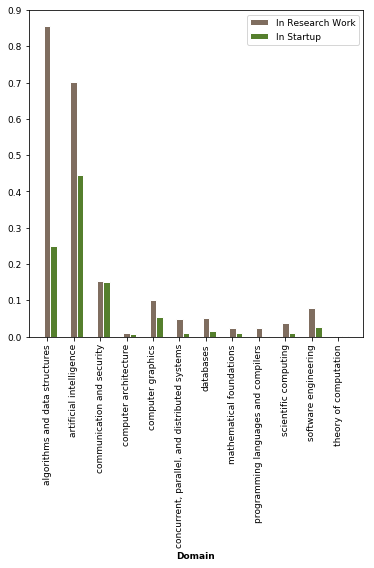

In [105]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
i = 0
 
# Set position of bar on X axis
r1 = np.arange(len(compare['in_papers']))
r2 = [x + barWidth for x in r1]
plt.figure(figsize=(6,6))
# Make the plot
plt.bar(r1, compare['in_papers'], color='#7f6d5f', width=barWidth, edgecolor='white', label='In Research Work')
plt.bar(r2, compare['in_startup'], color='#557f2d', width=barWidth, edgecolor='white', label='In Startup')
 
# Add xticks on the middle of the group bars
plt.xlabel('Domain', fontweight='bold')
plt.xticks([r for r in range(len(compare['in_papers']))], [compare['domain'][0], compare['domain'][1], 
                                                                      compare['domain'][2], compare['domain'][3],
                                                                      compare['domain'][4], compare['domain'][5],
                                                                      compare['domain'][6], compare['domain'][7],
                                                                      compare['domain'][8], compare['domain'][9],
                                                                      compare['domain'][10], compare['domain'][11]], rotation=90)

# Create legend & Show graphic
plt.legend()

plt.show()


In [48]:
newsdf1 = pd.read_csv("data/articles1.csv")
newsdf2 = pd.read_csv("data/articles2.csv")
newsdf3 = pd.read_csv("data/articles3.csv")

In [49]:
news = pd.concat([newsdf1, newsdf2, newsdf3])

In [50]:
news = news.dropna(subset=['title', 'content'])

In [51]:
news['text'] = news[['content', 'title']].apply(lambda x: ' '.join(x), axis=1)

In [52]:
news = news.drop(columns={'Unnamed: 0'}, axis=1)

In [53]:
t1 = grid_search.predict(news['text'].values.tolist())

In [54]:
news['domain'] = pd.Series(t1).values

In [174]:
news.head(2).drop(columns={'url'},axis=1)

,id,title,publication,author,date,year,month,content,text,domain
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...,WASHINGTON — Congressional Republicans have...,communication and security
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood...","After the bullet shells get counted, the blood...",artificial intelligence


In [91]:
newsplot = news.groupby('domain').count().reset_index()

In [92]:
newsplot1 = newsplot[['domain','text']]

In [93]:
newsplot1

,domain,text
0,algorithms and data structures,30179
1,artificial intelligence,93478
2,communication and security,9264
3,computer architecture,206
4,computer graphics,3733
5,"concurrent, parallel, and distributed systems",257
6,databases,2148
7,mathematical foundations,586
8,programming languages and compilers,36
9,scientific computing,1299


In [94]:
tempnews = newsplot1.drop([0,11,8])

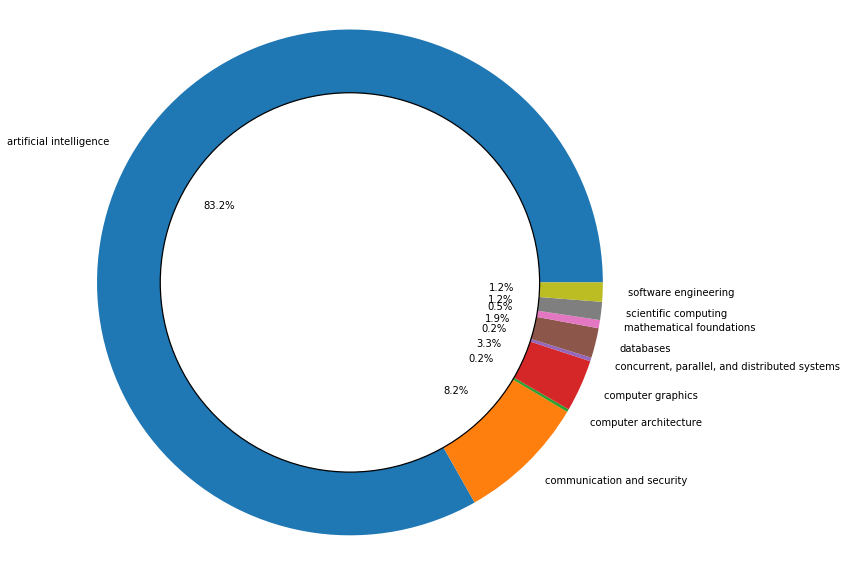

In [84]:
from matplotlib import colors as mcolors
plt.figure(figsize=(10,10))
colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)
labels = tempnews['domain'].head(10)
sizes = tempnews['text'].head(10)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
# colors = blend_soft_light(rgb, intensity)
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, textprops={'fontsize': 10})
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

               Fig: Popularity of domains in news articles

In [60]:
compare1 = pd.merge(dfplot1, newsplot1, on='domain')

In [61]:
compare1 = compare1.rename(index=str, columns={"text_x": "in_papers", "text_y": "in_news"})

In [62]:
compare1['in_news'].max()

93478

In [63]:
compare1['in_papers'] = compare1['in_papers']/(360000)
compare1['in_news'] = compare1['in_news']/(110000)

In [64]:
# compare1['in_papers'] = compare1['in_papers']/(compare1['in_papers'].max())
# compare1['in_news'] = compare1['in_news']/(compare1['in_news'].max())

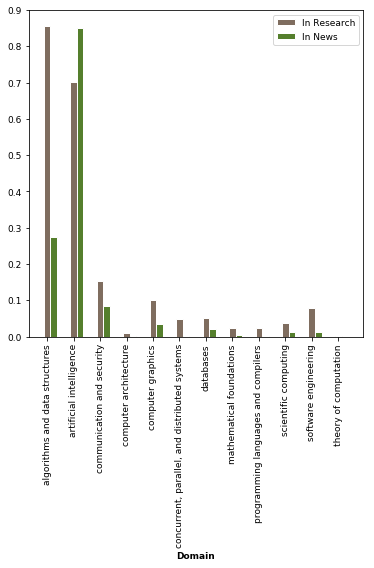

In [108]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(compare['in_papers']))
r2 = [x + barWidth for x in r1]
 
plt.figure(figsize=(6,6))
# Make the plot
plt.bar(r1, compare1['in_papers'], color='#7f6d5f', width=barWidth, edgecolor='white', label='In Research')
plt.bar(r2, compare1['in_news'], color='#557f2d', width=barWidth, edgecolor='white', label='In News')
 
# Add xticks on the middle of the group bars
plt.xlabel('Domain', fontweight='bold')
plt.xticks([r for r in range(len(compare1['in_papers']))], [compare1['domain'][0], compare1['domain'][1], 
                                                                      compare1['domain'][2], compare1['domain'][3],
                                                                      compare1['domain'][4], compare1['domain'][5],
                                                                      compare1['domain'][6], compare1['domain'][7],
                                                                      compare1['domain'][8], compare1['domain'][9],
                                                                      compare1['domain'][10], compare1['domain'][11]], rotation=90)
 
# Create legend & Show graphic
plt.legend()
plt.show()


In [75]:
newsdomains = news[['domain','year']]

In [76]:
newsdomains = newsdomains.fillna(2011)

In [77]:
newsdomains['year'] = newsdomains['year'].astype(int)

In [86]:
sorted(newsdomains.year.unique())

[2000,
 2003,
 2004,
 2005,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [80]:
df.head()

,abstract,authors,id,n_citation,references,title,venue,year,text,domain
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",00127ee2-cb05-48ce-bc49-9de556b93346,0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,The purpose of this study is to develop a lear...,communication and security
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",001c58d3-26ad-46b3-ab3a-c1e557d16821,50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,This paper describes the design and implementa...,computer graphics
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",001c8744-73c4-4b04-9364-22d31a10dbf1,50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,This article applied GARCH model instead AR or...,artificial intelligence
10,Recent achievements in Natural Language Proces...,"[Ankita Brahmachari, Priya Singh, Avdhesh Garg...",00a119c4-d367-4607-b3c8-b237f2971bff,0,"[84d47128-58d0-4187-aa44-389fde7d5c83, e0dce69...",Identifying Psychological Theme Words from Emo...,,2013,Recent achievements in Natural Language Proces...,artificial intelligence
12,"Recently, Bridges and Reich introduced the con...","[Alvaro L. Islas, Constance M. Schober]",00bcf2d5-1592-46b0-81fd-933f90b5ecca,50,[],Multisymplectic Spectral Methods for the Gross...,international conference on conceptual structures,2002,"Recently, Bridges and Reich introduced the con...",algorithms and data structures


In [81]:
dfdomains = df[['year','domain']]

In [89]:
df_1 = dfdomains[(dfdomains['year'] >= 2000) & (dfdomains['year'] <= 2001)]
df_2 = dfdomains[(dfdomains['year'] >= 2002) & (dfdomains['year'] <= 2003)]
df_3 = dfdomains[(dfdomains['year'] >= 2004) & (dfdomains['year'] <= 2005)]
df_4 = dfdomains[(dfdomains['year'] >= 2006) & (dfdomains['year'] <= 2007)]
df_5 = dfdomains[(dfdomains['year'] >= 2008) & (dfdomains['year'] <= 2009)]
df_6 = dfdomains[(dfdomains['year'] >= 2010) & (dfdomains['year'] <= 2011)]
df_7 = dfdomains[(dfdomains['year'] >= 2012) & (dfdomains['year'] <= 2013)]
df_8 = dfdomains[(dfdomains['year'] >= 2014) & (dfdomains['year'] <= 2015)]
df_9 = dfdomains[(dfdomains['year'] >= 2016) & (dfdomains['year'] <= 2017)]

In [116]:
df_1.head()

,year,domain
35,2000,algorithms and data structures
147,2001,artificial intelligence
157,2001,artificial intelligence
177,2000,artificial intelligence
188,2001,algorithms and data structures


In [117]:
c1 = collections.defaultdict(int)
for index, row in df_1.iterrows():
    c1[row['domain']] += 1
c1 = pd.DataFrame.from_dict(c1, orient = 'index').reset_index()
c1 = c1.rename(columns={'index': 'domain', 0: 'frequency'})
c1 = c1.sort_values(by=['frequency'], ascending = False)
c1['year'] = '2000-2001'

In [119]:
c2 = collections.defaultdict(int)
for index, row in df_2.iterrows():
    c2[row['domain']] += 1
c2 = pd.DataFrame.from_dict(c2, orient = 'index').reset_index()
c2 = c2.rename(columns={'index': 'domain', 0: 'frequency'})
c2 = c2.sort_values(by=['frequency'], ascending = False)
c2['year'] = '2002-2003'

In [121]:
c3 = collections.defaultdict(int)
for index, row in df_3.iterrows():
    c3[row['domain']] += 1
c3 = pd.DataFrame.from_dict(c3, orient = 'index').reset_index()
c3 = c3.rename(columns={'index': 'domain', 0: 'frequency'})
c3 = c3.sort_values(by=['frequency'], ascending = False)
c3['year'] = '2004-2005'

In [122]:
c4 = collections.defaultdict(int)
for index, row in df_4.iterrows():
    c4[row['domain']] += 1
c4 = pd.DataFrame.from_dict(c4, orient = 'index').reset_index()
c4 = c4.rename(columns={'index': 'domain', 0: 'frequency'})
c4 = c4.sort_values(by=['frequency'], ascending = False)
c4['year'] = '2006-2007'

In [123]:
c5 = collections.defaultdict(int)
for index, row in df_5.iterrows():
    c5[row['domain']] += 1
c5 = pd.DataFrame.from_dict(c5, orient = 'index').reset_index()
c5 = c5.rename(columns={'index': 'domain', 0: 'frequency'})
c5 = c5.sort_values(by=['frequency'], ascending = False)
c5['year'] = '2008-2009'

In [124]:
c6 = collections.defaultdict(int)
for index, row in df_6.iterrows():
    c6[row['domain']] += 1
c6 = pd.DataFrame.from_dict(c6, orient = 'index').reset_index()
c6 = c6.rename(columns={'index': 'domain', 0: 'frequency'})
c6 = c6.sort_values(by=['frequency'], ascending = False)
c6['year'] = '2010-2011'

In [125]:
c7 = collections.defaultdict(int)
for index, row in df_7.iterrows():
    c7[row['domain']] += 1
c7 = pd.DataFrame.from_dict(c7, orient = 'index').reset_index()
c7 = c7.rename(columns={'index': 'domain', 0: 'frequency'})
c7 = c7.sort_values(by=['frequency'], ascending = False)
c7['year'] = '2012-2013'

In [126]:
c8 = collections.defaultdict(int)
for index, row in df_8.iterrows():
    c8[row['domain']] += 1
c8 = pd.DataFrame.from_dict(c8, orient = 'index').reset_index()
c8 = c8.rename(columns={'index': 'domain', 0: 'frequency'})
c8 = c8.sort_values(by=['frequency'], ascending = False)
c8['year'] = '2014-2015'

In [127]:
c9 = collections.defaultdict(int)
for index, row in df_9.iterrows():
    c9[row['domain']] += 1
c9 = pd.DataFrame.from_dict(c9, orient = 'index').reset_index()
c9 = c9.rename(columns={'index': 'domain', 0: 'frequency'})
c9 = c9.sort_values(by=['frequency'], ascending = False)
c9['year'] = '2016-2017'

In [143]:
news_1 = newsdomains[(newsdomains['year'] >= 2000) & (newsdomains['year'] <= 2001)]
news_2 = newsdomains[(newsdomains['year'] >= 2002) & (newsdomains['year'] <= 2003)]
news_3 = newsdomains[(newsdomains['year'] >= 2004) & (newsdomains['year'] <= 2005)]
news_4 = newsdomains[(newsdomains['year'] >= 2006) & (newsdomains['year'] <= 2007)]
news_5 = newsdomains[(newsdomains['year'] >= 2008) & (newsdomains['year'] <= 2009)]
news_6 = newsdomains[(newsdomains['year'] >= 2010) & (newsdomains['year'] <= 2011)]
news_7 = newsdomains[(newsdomains['year'] >= 2012) & (newsdomains['year'] <= 2013)]
news_8 = newsdomains[(newsdomains['year'] >= 2014) & (newsdomains['year'] <= 2015)]
news_9 = newsdomains[(newsdomains['year'] >= 2016) & (newsdomains['year'] <= 2017)]

In [128]:
d1 = collections.defaultdict(int)
for index, row in news_1.iterrows():
    d1[row['domain']] += 1
d1 = pd.DataFrame.from_dict(d1, orient = 'index').reset_index()
d1 = d1.rename(columns={'index': 'domain', 0: 'frequency'})
d1 = d1.sort_values(by=['frequency'], ascending = False)
d1['year'] = '2000-2001'

In [129]:
d2 = collections.defaultdict(int)
for index, row in news_2.iterrows():
    d2[row['domain']] += 1
d2 = pd.DataFrame.from_dict(d2, orient = 'index').reset_index()
d2 = d2.rename(columns={'index': 'domain', 0: 'frequency'})
d2 = d2.sort_values(by=['frequency'], ascending = False)
d2['year'] = '2002-2003'

In [130]:
d3 = collections.defaultdict(int)
for index, row in news_3.iterrows():
    d3[row['domain']] += 1
d3 = pd.DataFrame.from_dict(d3, orient = 'index').reset_index()
d3 = d3.rename(columns={'index': 'domain', 0: 'frequency'})
d3 = d3.sort_values(by=['frequency'], ascending = False)
d3['year'] = '2004-2005'

In [131]:
d4 = collections.defaultdict(int)
for index, row in news_4.iterrows():
    d4[row['domain']] += 1
d4 = pd.DataFrame.from_dict(d4, orient = 'index').reset_index()
d4 = d4.rename(columns={'index': 'domain', 0: 'frequency'})
d4 = d4.sort_values(by=['frequency'], ascending = False)
d4['year'] = '2006-2007'

In [132]:
d5 = collections.defaultdict(int)
for index, row in news_5.iterrows():
    d5[row['domain']] += 1
d5 = pd.DataFrame.from_dict(d5, orient = 'index').reset_index()
d5 = d5.rename(columns={'index': 'domain', 0: 'frequency'})
d5 = d5.sort_values(by=['frequency'], ascending = False)
d5['year'] = '2008-2009'

In [133]:
d6 = collections.defaultdict(int)
for index, row in news_6.iterrows():
    d6[row['domain']] += 1
d6 = pd.DataFrame.from_dict(d6, orient = 'index').reset_index()
d6 = d6.rename(columns={'index': 'domain', 0: 'frequency'})
d6 = d6.sort_values(by=['frequency'], ascending = False)
d6['year'] = '2010-2011'

In [134]:
d7 = collections.defaultdict(int)
for index, row in news_7.iterrows():
    d7[row['domain']] += 1
d7 = pd.DataFrame.from_dict(d7, orient = 'index').reset_index()
d7 = d7.rename(columns={'index': 'domain', 0: 'frequency'})
d7 = d7.sort_values(by=['frequency'], ascending = False)
d7['year'] = '2012-2013'

In [135]:
d8 = collections.defaultdict(int)
for index, row in news_8.iterrows():
    d8[row['domain']] += 1
d8 = pd.DataFrame.from_dict(d8, orient = 'index').reset_index()
d8 = d8.rename(columns={'index': 'domain', 0: 'frequency'})
d8 = d8.sort_values(by=['frequency'], ascending = False)
d8['year'] = '2014-2015'

In [136]:
d9 = collections.defaultdict(int)
for index, row in news_9.iterrows():
    d9[row['domain']] += 1
d9 = pd.DataFrame.from_dict(d9, orient = 'index').reset_index()
d9 = d9.rename(columns={'index': 'domain', 0: 'frequency'})
d9 = d9.sort_values(by=['frequency'], ascending = False)
d9['year'] = '2016-2017'

In [146]:
tobemerged1 = [c1,c2,c3,c4,c5,c6,c7,c8,c9]
tobemerged2 = [d1,d2,d3,d4,d5,d6,d7,d8,d9]

In [147]:
freqinpapers = pd.concat(tobemerged1)
freqinnews = pd.concat(tobemerged2)

In [311]:
aipaper = freqinpapers[freqinpapers['domain']=='artificial intelligence']
ainews = freqinnews[freqinnews['domain']=='artificial intelligence']
ai = pd.merge(aipaper, ainews, on='year')
ai = ai.rename(columns={'frequency_x': 'In Papers', 'frequency_y': 'In News'})
ai = ai.drop(columns={'domain_x','domain_y'}, axis=1)

In [312]:
ai

,In Papers,year,In News
0,9861,2000-2001,1
1,13553,2002-2003,2
2,23494,2006-2007,1
3,24860,2008-2009,4
4,32458,2010-2011,1456
5,37589,2012-2013,205
6,41099,2014-2015,2500
7,3716,2016-2017,73962


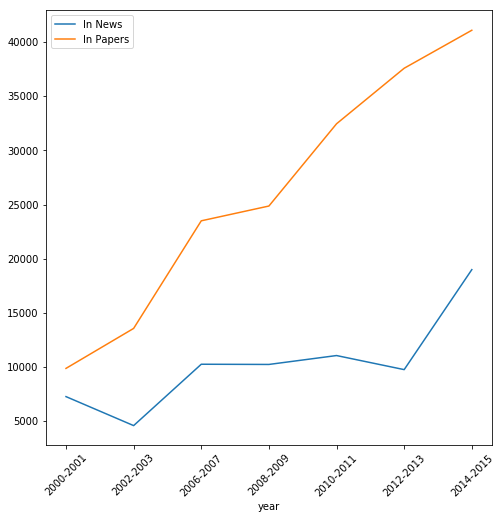

In [314]:
ai.plot(x="year", y=["In News", "In Papers"], figsize = (8,8))
plt.xticks([0,1,2,3,4,5,6],["2000-2001", "2002-2003", "2006-2007", "2008-2009", "2010-2011", "2012-2013", "2014-2015"], rotation = 45)
plt.show()

    Fig: Comparing yearly trend of Artificial Intelligence 
                in News Articles and Research Work

In [316]:
from scipy import stats
stats.pearsonr(ai['In News'], ai['In Papers'])

(0.79983340254912749, 0.030810564928973227)

In [317]:
cnspaper = freqinpapers[freqinpapers['domain']=='communication and security']
cnsnews = freqinnews[freqinnews['domain']=='communication and security']
cns = pd.merge(cnspaper, cnsnews, on='year')
cns = cns.rename(columns={'frequency_x': 'In Papers', 'frequency_y': 'In News'})
cns = cns.drop(columns={'domain_x','domain_y'}, axis=1)

In [367]:
from scipy import stats
stats.pearsonr(cns['In News'], cns['In Papers'])

(0.95708211511344277, 0.010604142638071754)

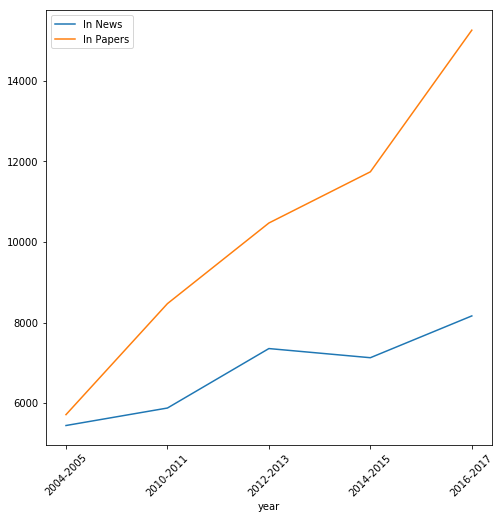

In [368]:
cns.plot(x="year", y=["In News", "In Papers"], figsize = (8,8))
plt.xticks([0,1,2,3,4],['2004-2005', '2010-2011', '2012-2013', '2014-2015', '2016-2017'], rotation = 45)
plt.show()

In [231]:
cns.year.unique()

array(['2004-2005', '2010-2011', '2012-2013', '2014-2015', '2016-2017'], dtype=object)

In [359]:
adspaper = freqinpapers[freqinpapers['domain']=='algorithms and data structures']
adsnews = freqinnews[freqinnews['domain']=='algorithms and data structures']
ads = pd.merge(adspaper, adsnews, on='year')
ads = ads.rename(columns={'frequency_x': 'In Papers', 'frequency_y': 'In News'})
ads = ads.drop(columns={'domain_x','domain_y'}, axis=1)

In [266]:
from scipy import stats
stats.pearsonr(ads['In News'], ads['In Papers'])

(-0.80119074123485456, 0.05535870201495955)

In [233]:
cgpaper = freqinpapers[freqinpapers['domain']=='computer graphics']
cgnews = freqinnews[freqinnews['domain']=='computer graphics']
cg = pd.merge(cgpaper, cgnews, on='year')
cg = cg.rename(columns={'frequency_x': 'In Papers', 'frequency_y': 'In News'})
cg = cg.drop(columns={'domain_x','domain_y'}, axis=1)

In [267]:
from scipy import stats
stats.pearsonr(cg['In News'], cg['In Papers'])

(-0.98405825286990001, 0.015941747130099996)

In [269]:
sfpaper = freqinpapers[freqinpapers['domain']=='software engineering']
sfnews = freqinnews[freqinnews['domain']=='software engineering']
sf = pd.merge(sfpaper, sfnews, on='year')
sf = sf.rename(columns={'frequency_x': 'In Papers', 'frequency_y': 'In News'})
sf = sf.drop(columns={'domain_x','domain_y'}, axis=1)

In [270]:
from scipy import stats
stats.pearsonr(sf['In News'], sf['In Papers'])

(-0.99950260145768965, 0.020080077191665886)

In [215]:
ai

,In Papers,year,In News
0,9861,2000-2001,3473
1,13553,2002-2003,5325
2,23494,2006-2007,9463
3,24860,2008-2009,11356
4,32458,2010-2011,20736
5,37589,2012-2013,21982
6,41099,2014-2015,24758


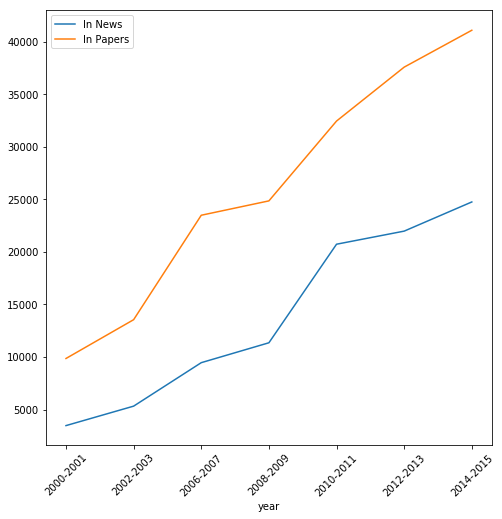

In [257]:
ai.plot(x="year", y=["In News", "In Papers"], figsize = (8,8))
plt.xticks([0,1,2,3,4,5,6],["2000-2001", "2002-2003", "2006-2007", "2008-2009", "2010-2011", "2012-2013", "2014-2015"], rotation = 45)
plt.show()

    Fig: Comparing yearly trend of Artificial Intelligence 
                in News Articles and Research Work

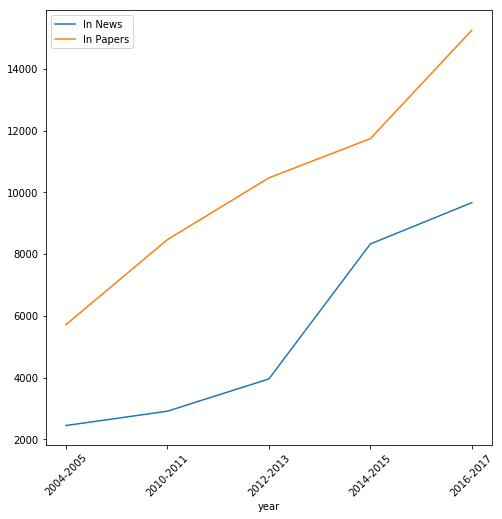

In [258]:
cns.plot(x="year", y=["In News", "In Papers"], figsize = (8,8))
plt.xticks([0,1,2,3,4],['2004-2005', '2010-2011', '2012-2013', '2014-2015', '2016-2017'], rotation = 45)
plt.show()

    Fig: Comparing yearly trend of Communication and Security 
                in News Articles and Research Work

In [260]:
from scipy import stats
stats.pearsonr(cns['In News'], cns['In Papers'])

(0.9141903476761406, 0.02978294610711028)